### Pennylane Intro to QSVT

**Aryan Bawa**  

In this notebook, I follow Pennylane.a`i's intro to QSVT tutorial [here](https://pennylane.ai/qml/demos/tutorial_intro_qsvt) and make some notes about the process. 

In [1]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt

The crux of QSVT is really the QSP step. Given a unitary matrix to encode and a By altering $U(a)$ and $S(\phi)$, keeping $a$ fixed and varying $\phi,$ the top-left corner of the resulting matrix is a polynomial transformation of $a:$    

$$ S(\phi_0)\prod_{k=1}^d U(a) S(\phi_k) = \begin{pmatrix}
    P(a) & *\\
    * & *
    \end{pmatrix}.$$

$$ U(a) = \begin{pmatrix} a & \sqrt{1-a^2}\\
    \sqrt{1-a^2} & -a
    \end{pmatrix} $$

The U(a) above is just one possible scalar encoding example. Every time $U(a)$ is multiplied, its entries are transformed into a polynomial of higher degree. By interweaving signal processing operators, the coefficients of the polynomial can be tuned. The main QSP theorem states that it is possible to find angles that implement a large class of complex polynomial transformations $P(a)$ with max degree and parity determined by the number of angles. The results of the theorem can be extended to show that using $d+1$ angles that implement any real polynomial of parity $d \text{mod} 2$ and maximum degree $d$. Therefore, there are multiple QSP sequences that can be used to implement real polynomials of indefinite parity. the qsvt() function in pennylane calculates the angle internally.


The first example pennylane uses is the encoding of Legendre polynomial $\frac{(5x^3 -3x)}{2}.$ This is done by putting the coefficients of the matrix in an array. This 1x5 matrix is made unitary via block encoding. 

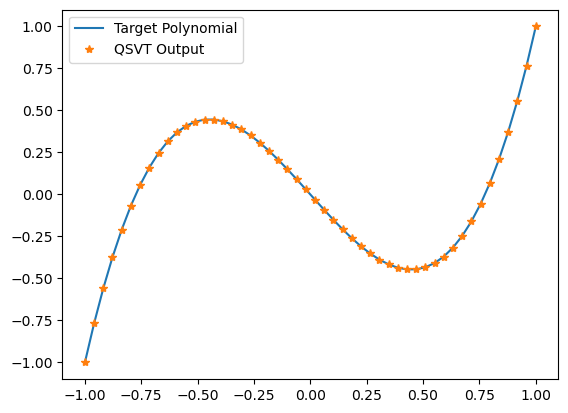

In [24]:
# coefficients of polynomial in an array
target_poly = [0, -3 * 0.5, 0, 5 * 0.5]

def qsvt_output(a):
    # output matrix
    out = qml.matrix(qml.qsvt(a, target_poly, encoding_wires=[0], block_encoding="embedding"))
    return out[0,0] # top left element is the output

# 100 evenly spaced values for a between 0 and 1
a_vals = np.linspace(-1, 1, 50) 
# compute the output for each value of a -> neglect small imaginary part with np.real
qsvt = np.real([qsvt_output(a) for a in a_vals])
# compute the target polynomial values for each a   
target = [np.polyval(target_poly[::-1], a) for a in a_vals]

# compare the qsvt output with the target polynomial
plt.plot(a_vals, target, label="Target Polynomial")
plt.plot(a_vals, qsvt, "*", label="QSVT Output")


plt.legend()
plt.show()

Notice how the QSVT essentially just approximates the target polynomial, sort of like a taylor approximation.

A few notes about the pennylane package itself - remember to go through the steps of setting up an environment.yml with a pip install, as this gives the most updated version of pennylane. Pennylane on the conda forge is pretty outdated. To do this, slap this into the bottom of the environment.yml file:

Generate environment.yml by running conda env export > environment.yml. Update environment or create new environment with conda env update -f environment.yml or conda env create -f environment.yml.

Continuing on with QSVT itself, the tutorial goes more into block encoding. The first example encoded a scalar inside a 2x2 unitary $U(a)$, but a matrix can be encoded as well. An encoded matrix will have a similar form to the scalar case: 

$$ U(A) = 
\begin{pmatrix} 
A & \sqrt{I-A A^\dagger}\\
\sqrt{I-A^\dagger A} & -A^\dagger
\end{pmatrix} $$

The $U(A)$ operator is a valid unitary regardless of the form of $A$, even if it isn't a square matrix. $A$, however, must be normalized such that its largest singular value is bounded by 1. Encoding a matrix inside of a larger unitary like this is known as block encoding. Pennylane's block encoding operation follows the construction above, so A is encoded in the top-left block. An example is below.

In [ ]:
# constructing the square matrix

A = [[0.1, 0.2], [0.3, 0.4]]
U1 = qml.BlockEncode(A, wires=range(2))
print("U(A) =")
print(np.round(qml.matrix(U1), 2))

U(A) =
[[ 0.1   0.2   0.97 -0.06]
 [ 0.3   0.4  -0.06  0.86]
 [ 0.95 -0.08 -0.1  -0.3 ]
 [-0.08  0.89 -0.2  -0.4 ]]


The output above is a unitary matrix with $A$ encoded in the top-left block. Here is the below with a rectangular matrix:

In [16]:
B = [[0.3, 0.238, -.238], [0.5, -0.5, 0.5]]
U2 = qml.BlockEncode(B, wires=range(3))
print("U(B) =")
print(np.round(qml.matrix(U2), 3))

U(B) =
[[ 0.3    0.238 -0.238  0.89   0.063  0.     0.     0.   ]
 [ 0.5   -0.5    0.5    0.063  0.496  0.     0.     0.   ]
 [ 0.792  0.129 -0.129 -0.3   -0.5    0.     0.     0.   ]
 [ 0.129  0.797  0.203 -0.238  0.5    0.     0.     0.   ]
 [-0.129  0.203  0.797  0.238 -0.5    0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     1.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     1.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     1.   ]]


The hardest part about QSVT is implementing circuits that actually use these block encodings. Pennylane covers one popular approach, where $A$ is expressed as a linear combination of unitaries and associated $\text{PREPARE}$ and $\text{SELECT}$ operators are defined. Then the operator

$$ U = \text{PREP}^\dagger \cdot \text{SEL} \cdot \text{PREP} $$

Is a block encoding up to some constant factor. Now with the block encoded matrix, we have to apply QSP similarly to the scalar encoding case. However, the signal processing operator $S(\phi)$ must be generalized to higher dimensions. To do so, a diagonal unitary is used where the phase $e^{i\phi}$ is applied to the elements of the subspace determined by the block, but all others are $e^{-i\phi}$. E.g, for $A$,

$$ \begin{pmatrix} e^{i\phi} & 0 & 0 & 0\\
    0 & e^{i\phi} & 0 & 0 \\
    0 & 0 & e^{-i\phi} & 0\\
    0 & 0 & 0 & e^{-i\phi} \\
    \end{pmatrix}.$$

This is a projector-controlled phase gate for which the symbol $\Pi(\phi)$ is used. When $A$ is not square, two operators must be defined: one for the row subspace and one for the column subspace. Projector-controlled phase gates are implemented in Pennylane with PCPhase:

In [17]:
dim = 2
phi = np.pi / 2
pcp = qml.PCPhase(phi, dim, wires=range(2))
print("Pi:")
print(np.round(qml.matrix(pcp), 2))

Pi:
[[0.+1.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+1.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.-1.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.-1.j]]


By alternating $U(A)$ and $\Pi(\phi)$ as with the single dimensional case, we have:
$$\left[\prod_{k=1}^{d/2}\Pi_{\phi_{2k-1}}U(A)^\dagger \tilde{\Pi}_{\phi_{2k}} U(A)\right]\Pi_{\phi_{d+1}}=
    \begin{pmatrix} P(A) & *\\
    * & *
    \end{pmatrix}. $$
The tilde is used to determine whether the projector-controlled phase gates apply to the column or row subspaces. The polynomial transformation of A is defined in terms of its singular value decomposition: 

$$ P(A) = \sum_k P(\sigma_k)\ket{w_k}\bra{v_k} $$

When the polynomial degree is odd, the sequence is instead:

$$ \tilde{\Pi}_{\phi_1}\left[\prod_{k=1}^{(d-1)/2}\Pi_{\phi_{2k}}U(A)^\dagger \tilde{\Pi}_{\phi_{2k+1}} U(A)\right]\Pi_{\phi_{d+1}}=
    \begin{pmatrix}
    P(A) & *\\
    * & *
    \end{pmatrix} $$

As with QSP, it is possible to use the QSVT sequence to apply any real polynomial transformation up to degree $d$ and using $d + 1$ angles.

The end result of QSVT is the transformation of the singular values of a block encoded matrix without ever having to use singular value decomposition. Additionally, the number of operations used scales linearly with the degree of the target polynomial - $O(d)$.  If the block encoding circuits can be implemented in polynomial time in the number of qubits, the resulting quantum algorithm will also run in polynomial time. Using QSVT in pennylane amounts to using the qsvt() method.

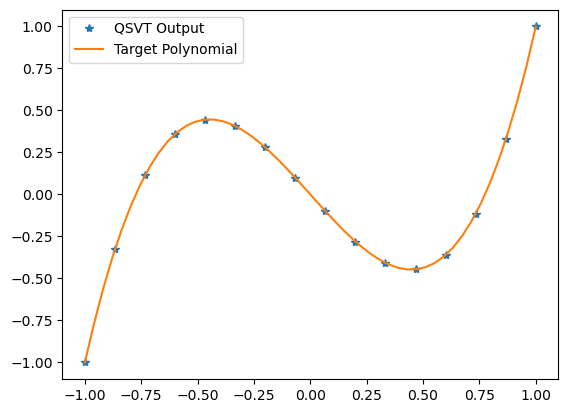

In [ ]:
eigvals = np.linspace(-1, 1, 16)
A = np.diag(eigvals)
wire_order = list(range(5))
U_A = qml.matrix(qml.qsvt, wire_order=wire_order)(
    A, target_poly, encoding_wires=wire_order, block_encoding="embedding"
) # block encoded in 5-qubit system

qsvt_A = np.real(np.diag(U_A))[:16] #retrieve transformed eigenvalues

plt.plot(eigvals, qsvt_A, "*", label="QSVT Output")
plt.plot(a_vals, target, label="Target Polynomial")

plt.legend()
plt.show()